In [3]:
import psycopg2 as pg
import pandas.io.sql as psql
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from nltk.corpus import wordnet as wn

In [10]:
def wordnet_graph(words):
     
    """
    Construct a semantic graph and labels for a set of object categories using 
    WordNet and NetworkX. 

    Parameters: 
    ----------
     words : set
         Set of words for all the categories. 

     Returns: 
     -------
     graph : graph
         Graph object containing edges and nodes for the network. 
     labels : dict
         Dictionary of all synset labels. 
     """
     
    graph = nx.DiGraph()
    labels = {}
    seen = set()

    def recurse(s):

        """ Recursively move up semantic hierarchy and add nodes / edges """  

        if not s in seen:                               # if not seen...
            seen.add(s)                                 # add to seen
            graph.add_node(s.name)                      # add node
            labels[s.name] = s.name().split(".")[0]     # add label
            hypernyms = s.hypernyms()                   # get hypernyms

            for s1 in hypernyms:                        # for hypernyms
                graph.add_node(s1.name)                 # add node
                graph.add_edge(s.name, s1.name)         # add edge between
                recurse(s1)                             # do so until top

    # build network containing all categories          
    for word in words:                                  # for all categories
        try:
            s = wn.synset(str(word) + str('.n.01'))     # create synset            
        except Exception as e:
            print(e)
            continue
        recurse(s)                                      # call recurse

    # return the graph and labels    
    return graph, labels

In [11]:
# get connected to the database
connection = pg.connect(user='scientist',
                        password='********',
                        host='127.0.01',
                        port='5432',
                        database='tensor_factorisation_wordnet')

In [12]:
entity = psql.read_sql('SELECT * FROM entity', connection)
entity.head()

,synset_id,name,sense_index
0,85227,city,1.0
1,85228,jurisprudence,2.0
2,85229,bird_genus,1.0
3,85230,individual,1.0
4,85231,armed_forces,1.0


In [13]:
entity_sample = entity.sample(n=10)['name']
entity_sample

27070                   procedure
36043                    autumnal
14540                     apatura
29619                       guide
36739                   canvasser
25067                    thiazine
30007    archosargus_rhomboidalis
21380                       cornu
27850                     eparchy
34368                     griddle
Name: name, dtype: object

In [14]:
categories = set()
for sample in entity_sample:
    name = '_'.join(sample.split())
    print(name)
    categories.add(name)

procedure
autumnal
apatura
guide
canvasser
thiazine
archosargus_rhomboidalis
cornu
eparchy
griddle


In [15]:
# create the graph and labels
graph, labels = wordnet_graph(categories)
 
print(f'labels: {labels}')

no lemma 'autumnal' with part of speech 'n'
labels: {<bound method Synset.name of Synset('thiazine.n.01')>: 'thiazine', <bound method Synset.name of Synset('organic_compound.n.01')>: 'organic_compound', <bound method Synset.name of Synset('compound.n.02')>: 'compound', <bound method Synset.name of Synset('chemical.n.01')>: 'chemical', <bound method Synset.name of Synset('material.n.01')>: 'material', <bound method Synset.name of Synset('substance.n.01')>: 'substance', <bound method Synset.name of Synset('matter.n.03')>: 'matter', <bound method Synset.name of Synset('physical_entity.n.01')>: 'physical_entity', <bound method Synset.name of Synset('entity.n.01')>: 'entity', <bound method Synset.name of Synset('part.n.01')>: 'part', <bound method Synset.name of Synset('relation.n.01')>: 'relation', <bound method Synset.name of Synset('abstraction.n.06')>: 'abstraction', <bound method Synset.name of Synset('procedure.n.01')>: 'procedure', <bound method Synset.name of Synset('activity.n.01')

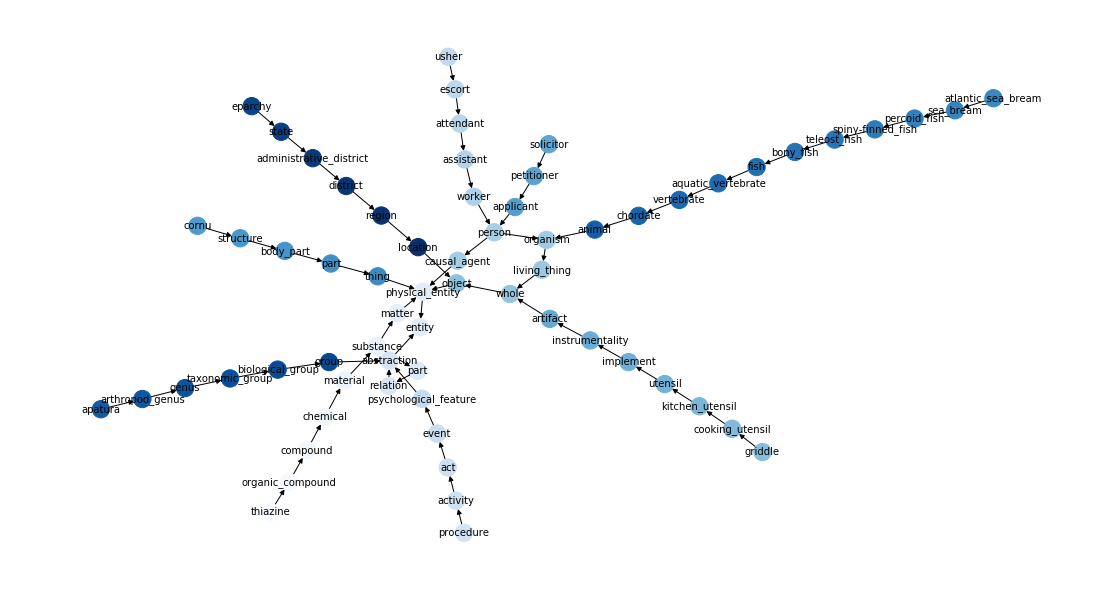

In [18]:
plt.figure(figsize=(15, 8))
# draw the graph
pos=graphviz_layout(graph)
nx.draw(graph, 
        pos=graphviz_layout(graph), 
        labels=labels,
        font_size=10,
        cmap=plt.cm.Blues,
        node_color=range(len(graph)),
        prog='dot')
plt.savefig('Wordnet.png', format='PNG')
plt.show()